In this notebook, we would look into the correlation between average eviction rates and building characteristics. Currently, we are looking at the numerical characteristics. 

In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [89]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy import stats

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# data source:
file_path1 = '/content/drive/My Drive/X999/bbl_evictions_merged.csv'

In [10]:
bbl_evictions_merged_raw = pd.read_csv(file_path1)

In [13]:
bbl_evictions_merged = bbl_evictions_merged_raw.copy()

In [17]:
display(bbl_evictions_merged.head()), bbl_evictions_merged.shape

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile
0,34859/16,53416,3476 SEYMOUR AVENUE,3-B,2017-01-03,BRONX,10469,Not an Ejectment,Possession,40.877620,...,walk-up,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",100+ units,True,mega,Q4 (largest 25%)
1,B57808/16,74242,1426 BRYANT AVENUE,10 AKA 2ND FL UNIT,2017-01-03,BRONX,10459,Not an Ejectment,Possession,40.830691,...,two-family,False,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",2-unit,False,small,Q3 (50-75%)
2,N069212/14,355977,1309 5TH AVENUE,24H,2017-01-03,MANHATTAN,10029,Not an Ejectment,Possession,40.797309,...,elevator,False,high-rise,"1970–1993, deregularization","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%)
3,K065455/16,367441,458 EAST 51 STREET,6A,2017-01-03,BROOKLYN,11203,Not an Ejectment,Possession,40.650624,...,elevator,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",21-100 units,True,very large,Q4 (largest 25%)
4,33992/16,458984,580 EAST 168TH STREE T,*,2017-01-03,BRONX,10456,Not an Ejectment,Possession,40.830494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(None, (74082, 39))

In [18]:
bbl_evictions_merged.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'bbl_clean', 'yearbuilt',
       'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea',
       'building_type', 'building_category', 'is_condo', 'floor_category',
       'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'is_llc', 'building_size_category',
       'size_quartile'],
      dtype='object')

In [19]:
building_characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile', 'yearbuilt', 'numfloors', 'unitsres'
]

In [26]:
nan_counts = bbl_evictions_merged[building_characteristics].isna().sum()
nan_percentages = (nan_counts / len(bbl_evictions_merged) * 100).round(3)
# percentage:.3f%

In [27]:
nan_counts, nan_percentages

(yearbuilt                     3770
 bldgclass                     3770
 numfloors                     3770
 unitsres                      3770
 ownername                     3770
 bldgarea                      3770
 building_type                 3770
 building_category             3770
 is_condo                      3770
 floor_category                3770
 rent_era                      3770
 architectural_style           3770
 economic_period               3770
 residential_units_category    3770
 is_llc                        3770
 building_size_category        3770
 size_quartile                 3770
 yearbuilt                     3770
 numfloors                     3770
 unitsres                      3770
 dtype: int64,
 yearbuilt                     5.089
 bldgclass                     5.089
 numfloors                     5.089
 unitsres                      5.089
 ownername                     5.089
 bldgarea                      5.089
 building_type                 5.089
 build

In [36]:
bbl_evictions_merged.shape

(74082, 39)

In [37]:
df = bbl_evictions_merged.copy()

In [38]:
df = bbl_evictions_merged.dropna(subset=['average_year_eviction_count'])

In [39]:
df.shape

(74082, 39)

In [50]:
df_clean = df.dropna(subset=building_characteristics)

In [51]:
df_clean.shape, 74082 - 70312
# good

((70312, 39), 3770)

In [53]:
df_clean['eviction_rate_per_unit'] = df_clean['average_year_eviction_count'] / df_clean['unitsres']
# Handle inf values that might result from division by zero
df_clean['eviction_rate_per_unit'] = df_clean['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)


In [55]:
display(df_clean.head())

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,eviction_rate_per_unit
0,34859/16,53416,3476 SEYMOUR AVENUE,3-B,2017-01-03,BRONX,10469,Not an Ejectment,Possession,40.877620,...,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",100+ units,True,mega,Q4 (largest 25%),0.016456
1,B57808/16,74242,1426 BRYANT AVENUE,10 AKA 2ND FL UNIT,2017-01-03,BRONX,10459,Not an Ejectment,Possession,40.830691,...,False,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",2-unit,False,small,Q3 (50-75%),0.500000
2,N069212/14,355977,1309 5TH AVENUE,24H,2017-01-03,MANHATTAN,10029,Not an Ejectment,Possession,40.797309,...,False,high-rise,"1970–1993, deregularization","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),0.006667
3,K065455/16,367441,458 EAST 51 STREET,6A,2017-01-03,BROOKLYN,11203,Not an Ejectment,Possession,40.650624,...,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",21-100 units,True,very large,Q4 (largest 25%),0.050314
6,50104/16,318266,598 E 183 ST AKA 2239 ADAMS PL,26,2017-01-03,BRONX,10457,Not an Ejectment,Possession,40.853070,...,False,mid-rise,"Pre-1947, pre-rent-control","1900–1920, Beaux-Arts","Pre-1929, pre-great depression",21-100 units,True,very large,Q4 (largest 25%),0.060345


In [83]:
building_evictions = df.groupby('bbl_clean').agg({
    'average_year_eviction_count': 'mean',
    'eviction_count': 'sum',
    'unitsres': 'first',
    'building_category': 'first',
    'building_type': 'first',
    'is_llc': 'first',
    'yearbuilt': 'first',
    'bldgclass': 'first',
    'numfloors': 'first',
    'bldgarea': 'first',
    'is_condo': 'first',
    'floor_category': 'first',
    'rent_era': 'first',
    'architectural_style': 'first',
    'economic_period': 'first',
    'residential_units_category': 'first',
    'building_size_category': 'first',
    'size_quartile': 'first'
}).reset_index()
building_evictions['eviction_rate_per_unit'] = building_evictions['average_year_eviction_count'] / building_evictions['unitsres']

In [86]:
characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile'
]
characteristics = list(dict.fromkeys(characteristics))
building_evictions['eviction_rate_per_unit'] = building_evictions['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)
building_evictions_clean = building_evictions.dropna(subset=['eviction_rate_per_unit'])
current_year = pd.Timestamp.now().year
building_evictions_clean['building_age'] = current_year - building_evictions_clean['yearbuilt']
characteristics.append('building_age')

In [115]:
print(f"total buildings analyzed: {len(building_evictions_clean)}")
print(f"average eviction rate per unit: {building_evictions_clean['eviction_rate_per_unit'].mean():.4f}")

total buildings analyzed: 31545
average eviction rate per unit: 0.3094


In [112]:
numerical_chars = building_evictions_clean[characteristics].select_dtypes(include=[np.number]).columns.tolist()
numerical_chars

['yearbuilt', 'numfloors', 'unitsres', 'bldgarea', 'building_age']

In [113]:
corr_data = pd.DataFrame()
for char in numerical_chars:
    correlation = building_evictions_clean[[char, 'eviction_rate_per_unit']].corr().iloc[0, 1]
    r, p_value = stats.pearsonr(
        building_evictions_clean[char].dropna(),
        building_evictions_clean.loc[building_evictions_clean[char].notna(), 'eviction_rate_per_unit']
    )
    corr_data = pd.concat([corr_data, pd.DataFrame({
        'characteristic': [char],
        'correlation': [correlation],
        'p_value': [p_value],
        'significant': [p_value < 0.05]
    })])

In [114]:
corr_data = corr_data.sort_values(by='correlation', key=abs, ascending=False)

print("correlation with eviction rate (only numerical characteristics):")
print(corr_data)

correlation with eviction rate (only numerical characteristics):
  characteristic  correlation        p_value  significant
0      numfloors    -0.394253   0.000000e+00         True
0       unitsres    -0.176111  4.032848e-218         True
0       bldgarea    -0.173245  4.858287e-211         True
0   building_age    -0.034417   9.700829e-10         True
0      yearbuilt     0.034417   9.700829e-10         True


Text(0.5, 1.0, 'Correlation with eviction rate (only numerical characteristics)')

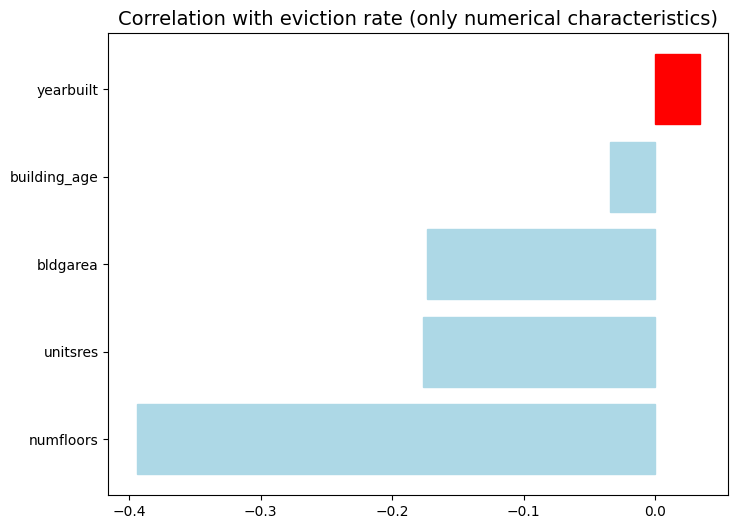

In [111]:
plt.figure(figsize=(8, 6))
bars = plt.barh(corr_data['characteristic'], corr_data['correlation'])
for i, bar in enumerate(bars):
    if corr_data.iloc[i]['significant']:
        if corr_data.iloc[i]['correlation'] > 0:
            bar.set_color('red')
        else:
            bar.set_color('lightblue')
    else:
        bar.set_color('gray')
plt.title('Correlation with eviction rate (only numerical characteristics)', fontsize=14)

- numfloors (-0.394253, p < 0.001) \
This is so far the strongest correlation, showing a moderately strong negative relationship between the number of floors in a building and eviction rates. This means that as the number of floors increases, the eviction rate tends to decrease. In other words, taller buildings generally have lower eviction rates per unit. This correlation is highly statistically significant (p-value almost zero).
- unitsres (-0.176111, p < 0.001) \
There's a weak to moderate negative correlation between the number of residential units and eviction rates. Buildings with more units tend to have somewhat lower eviction rates per unit. This is also highly statistically significant.
- bldgarea (-0.173245, p < 0.001) \
The building area shows a similar weak to moderate negative correlation with eviction rates. This means, larger buildings (by square footage) tend to have lower eviction rates per unit. This correlation is very similar in strength to the number of units, suggesting these two characteristics may have similar aspects of building size.
- building_age (-0.034417, p < 0.001) and yearbuilt (0.034417, p < 0.001) \
These show very weak correlations with eviction rates. Building age has a slight negative correlation, meaning older buildings have marginally higher eviction rates. 'Yearbuilt' shows the exact same correlation magnitude but positive. In this case, it actually makes sense as it's the inverse of building age. While statistically significant due to large sample size, the practical significance is quite small. In other words, building age appears to have minimal correlation with eviction rates compared to other factors.

**Overall qualitative interpretation:**

- Building size matters: The data strongly suggests that larger buildings (taller, more units, greater area) tend to have lower eviction rates per unit. Some of the factors could be:

- Professional management in larger buildings
- more systematic tenant screening processes
- economies of scale in maintenance and operations
- Potentially different ownership structures
